In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## <step1. 크롤링> : 네이버 플레이스 리뷰 크롤링

### [네이버플레이스 api]

In [62]:
import requests
import json


# 네이버 플레이스 API를 호출하기 위한 기본 주소입니다.
source_url = "https://store.naver.com/sogum/api/businesses?"

# 검색 규칙 파라미터를 추가합니다.
url_parameter_start = "start=1"
url_parameter_display = "&display="
url_parameter_query = "&query=강남역+고기집"
url_parameter_sorting = "&sortingOrder=precision"
url_concat = source_url + url_parameter_start + \
            url_parameter_display + str(100) + url_parameter_query + url_parameter_sorting

# 반환받은 API 데이터에 json.loads 함수를 사용합니다.
json_data = requests.get(url_concat).text
restaurant_list_data = json.loads(json_data)

# 관련도순 상위 100개의 고기집 리스트 정보를 출력합니다.
print(str(restaurant_list_data)[:100]+"...")

{'query': {'select': '1', 'item': [{'rank': '1', 'region_keyword': '강남역', 'region_type': 'favor', 'r...


In [63]:
restaurant_list_data

{'query': {'select': '1',
  'item': [{'rank': '1',
    'region_keyword': '강남역',
    'region_type': 'favor',
    'region_info': {'name': '강남역 2호선',
     'fkey': '2',
     'x': '1270276241',
     'y': '374979526',
     'spot_id': '13479290',
     'bmap': '0',
     'coordinates': {'coordinate': [{'x': '127.0272121', 'y': '37.4926153'},
       {'x': '127.0228532', 'y': '37.5020801'},
       {'x': '127.0292005', 'y': '37.5038361'},
       {'x': '127.0334889', 'y': '37.4946773'},
       {'x': '127.0272796', 'y': '37.4926696'}]}},
    'biz_type': 'category',
    'biz': '고기집',
    'coordinate_mode': '0'},
   {'rank': '2',
    'region_keyword': '',
    'region_type': 'none',
    'region_info': '',
    'biz_type': 'unknown',
    'biz': '강남역 고기집',
    'coordinate_mode': '0'}],
  'type': 'local',
  'petrol': '0',
  'global_menu': '0'},
 'total': 935,
 'items': [{'id': '1670127583',
   'name': '무한야끼',
   'businessCategory': 'restaurant',
   'dbType': 'drt',
   'category': '육류,고기요리',
   'desc': '',


In [64]:
restaurant_id_list = []

# 100개씩의 API 호출 결과를 10번 가져옵니다.
for start_idx in [1, 101, 201]:
    
    # 네이버 플레이스 API를 호출하기 위한 기본 주소입니다.
    source_url = "https://store.naver.com/sogum/api/businesses?"
    
    # 검색 규칙 파라미터를 추가합니다.
    url_parameter_start = "start=" + str(start_idx)
    url_parameter_display = "&display="
    url_parameter_query = "&query=강남역+고기집"
    url_parameter_sorting = "&sortingOrder=precision"
    url_concat = source_url + url_parameter_start + \
                url_parameter_display + str(start_idx+99) + url_parameter_query + url_parameter_sorting
    print("request_url:", url_concat)
    json_data = requests.get(url_concat).text
    restaurant_list_data = json.loads(json_data)

    # 크롤링에 필요한 각 리뷰 상세 페이지의 id를 추출합니다.
    for restaurant in restaurant_list_data['items']:
        if 'moreBookingReviewsPath' in restaurant:
            restaurant_id_list.append(restaurant['id'])

restaurant_id_list = list(set(restaurant_id_list))

request_url: https://store.naver.com/sogum/api/businesses?start=1&display=100&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=101&display=200&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=201&display=300&query=강남역+고기집&sortingOrder=precision


### [맛집 리뷰 정보 크롤링]

In [71]:
import requests
from bs4 import BeautifulSoup
import re

columns = ['score', 'review']
df = pd.DataFrame(columns=columns)

# 리뷰 상세 페이지의 기본 주소입니다.
source_url_head = "https://store.naver.com/restaurants/detail?id="
source_url_tail = "&tab=bookingReview#_tab"

for idx in range(0, len(restaurant_id_list)):
    print("Crawl", str(int(idx/len(restaurant_id_list)*100)), "% complete..")
    
    # 앞서 추출한 리뷰 상세 페이지의 id를 기본 주소의 파라미터로 추가합니다.
    req = requests.get(source_url_head + str(restaurant_id_list[idx]) + source_url_tail)
    html = req.content
    soup = BeautifulSoup(html, 'lxml')
    review_area = soup.find(name="div", attrs={"class":"review_area"})

    # 리뷰가 없는 페이지는 아무 작업도 수행하지 않습니다.
    if review_area is None:
        continue

    # 개발자 도구로 살펴본 html 구조에서 리뷰의 점수, 텍스트 부분을 추출합니다.
    review_list = review_area.find_all(name="div", attrs={"class":"info_area"})
    for review in review_list:
        score = review.find(name="span", attrs={"class":"score"}).text
        review_txt = review.find(name="div", attrs={"class":"review_txt"}).text

        # 추출한 리뷰의 점수, 리뷰 텍스트를 데이터프레임으로 병합합니다.
        row = [score, review_txt]
        series = pd.Series(row, index=df.columns)
        df = df.append(series, ignore_index=True)
print("Crawl 100 %", "complete")

Crawl 0 % complete..
Crawl 1 % complete..
Crawl 3 % complete..
Crawl 5 % complete..
Crawl 7 % complete..
Crawl 9 % complete..
Crawl 10 % complete..
Crawl 12 % complete..
Crawl 14 % complete..
Crawl 16 % complete..
Crawl 18 % complete..
Crawl 20 % complete..
Crawl 21 % complete..
Crawl 23 % complete..
Crawl 25 % complete..
Crawl 27 % complete..
Crawl 29 % complete..
Crawl 30 % complete..
Crawl 32 % complete..
Crawl 34 % complete..
Crawl 36 % complete..
Crawl 38 % complete..
Crawl 40 % complete..
Crawl 41 % complete..
Crawl 43 % complete..
Crawl 45 % complete..
Crawl 47 % complete..
Crawl 49 % complete..
Crawl 50 % complete..
Crawl 52 % complete..
Crawl 54 % complete..
Crawl 56 % complete..
Crawl 58 % complete..
Crawl 60 % complete..
Crawl 61 % complete..
Crawl 63 % complete..
Crawl 65 % complete..
Crawl 67 % complete..
Crawl 69 % complete..
Crawl 70 % complete..
Crawl 72 % complete..
Crawl 74 % complete..
Crawl 76 % complete..
Crawl 78 % complete..
Crawl 80 % complete..
Crawl 81 % compl

In [90]:
df

,score,y,ko_text
0,5.0,1,모둠이랑 라면 다 너무너무 맜있어요사람들이 많으니 꼭 미리 예약하고 가세요
1,5.0,1,시원하고 쾌적한 공간에서 조리 완료되어 나온 음식을 먹을 수 있어서 굿굿 모듬과 특...
2,4.5,1,맛있어요 질도 좋고 항상 잘 먹어요 다만 라면이 너무 짜요
3,4.5,1,맛나요 자주먹습니다
4,5.0,1,굿구굿구구굿구굿국굿
...,...,...,...
440,5.0,1,너무 친절하시고 맛도 좋고 언제가도 만족이에요
441,5.0,1,만족합니다
442,5.0,1,맛있음요
443,4.0,1,고기가 참 맛있습니다


In [86]:
# 4점 이상의 리뷰는 긍정 리뷰, 3점 이하의 리뷰는 부정 리뷰로 평가합니다.
df['y'] = df['score'].apply(lambda x: 1 if float(x) > 3 else 0)
print(df.shape)
df.head()

(445, 3)


,score,y,ko_text
0,5.0,1,모둠이랑 라면 다 너무너무 맜있어요사람들이 많으니 꼭 미리 예약하고 가세요
1,5.0,1,시원하고 쾌적한 공간에서 조리 완료되어 나온 음식을 먹을 수 있어서 굿굿 모듬과 특...
2,4.5,1,맛있어요 질도 좋고 항상 잘 먹어요 다만 라면이 너무 짜요
3,4.5,1,맛나요 자주먹습니다
4,5.0,1,굿구굿구구굿구굿국굿


In [87]:
df.to_csv('review_data.csv',index=False)
df=pd.read_csv('./review_data.csv')

## <step2. 전처리> : TF-IDF를 이용한 핵심어 추출

### [형태소 추출하기]
**한글 텍스트로 전처리**

In [88]:
import re

# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거
def text_cleaning(text):
    # 한글의 정규표현식으로 한글만 추출합니다.
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

In [89]:
# 함수를 적용하여 리뷰에서 한글만 추출합니다.
df['ko_text'] = df['review'].apply(lambda x: text_cleaning(x))
del df['review']
df.head()

KeyError: 'review'

**형태소 단위호 추출**

In [96]:
from konlpy.tag import Okt

# konply라이브러리로 텍스트 데이터에서 형태소를 추출합니다. 
def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word, tag) for word, tag in pos]
    return pos

# 형태소 추출 동작을 테스트 합니다. 
result = get_pos(df['ko_text'][0])
print(result)

['모/Noun', '둠이랑/Verb', '라면/Noun', '다/Adverb', '너무/Adverb', '너무/Adverb', '맜/Noun', '있어요/Adjective', '사람/Noun', '들/Suffix', '이/Josa', '많으니/Adjective', '꼭/Noun', '미리/Noun', '예약/Noun', '하고/Josa', '가세/Noun', '요/Josa']


### [분류 모델의 학습데이터로 변환하기]
**corpus index  생성하기**\
-***오류 주소 참고하기: https://www.it-swarm-ko.tech/ko/python/scikitlearn%ec%9d%98-tfidfvectorizer-valueerror-npnan%ec%9d%80-%ec%9e%98%eb%aa%bb%eb%90%9c-%eb%ac%b8%ec%84%9c%ec%9e%85%eb%8b%88%eb%8b%a4/826501124/***

In [102]:
from sklearn.feature_extraction.text import CountVectorizer

# 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x))
X = index_vectorizer.fit_transform(df['ko_text'].values.astype('U').tolist())

In [103]:
X.shape

(445, 2254)

In [104]:
print(str(index_vectorizer.vocabulary_)[:100]+'..')

{'모/Noun': 796, '둠이랑/Verb': 555, '라면/Noun': 604, '다/Adverb': 429, '너무/Adverb': 376, '맜/Noun': 722, '..


In [105]:
print(df['ko_text'][0])
print(X[0])

모둠이랑 라면 다 너무너무 맜있어요사람들이 많으니 꼭 미리 예약하고 가세요
  (0, 796)	1
  (0, 555)	1
  (0, 604)	1
  (0, 429)	1
  (0, 376)	2
  (0, 722)	1
  (0, 1636)	1
  (0, 1037)	1
  (0, 567)	1
  (0, 1528)	1
  (0, 670)	1
  (0, 298)	1
  (0, 852)	1
  (0, 1416)	1
  (0, 2104)	1
  (0, 33)	1
  (0, 1464)	1


**TF-IDF로 변환**

In [108]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF 방법으로, 형태소를 벡터 형태의 학습데이터셋(X데이터)으로 변환합니다.
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

In [109]:
print(X.shape)
print(X[0])

(445, 2254)
  (0, 2104)	0.17943595475540527
  (0, 1636)	0.2687322232770961
  (0, 1528)	0.11401591251985005
  (0, 1464)	0.19622020208604363
  (0, 1416)	0.16947150651760517
  (0, 1037)	0.21180582096166642
  (0, 852)	0.2796532143206639
  (0, 796)	0.2796532143206639
  (0, 722)	0.31357691100016266
  (0, 670)	0.29373282055681704
  (0, 604)	0.2687322232770961
  (0, 567)	0.1778821242821677
  (0, 555)	0.31357691100016266
  (0, 429)	0.17211764007497532
  (0, 376)	0.25786429360667984
  (0, 298)	0.23014389876554237
  (0, 33)	0.2796532143206639


## <step3. 분류> : 긍정 부정 리뷰 분류하기
### [분류 모델링]
**데이터 셋 분리**

In [128]:
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print(x_train.shape)
print(x_test.shape)

(311, 2254)
(134, 2254)


**Logistic Regression**

In [129]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 로지스틱 회귀모델을 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 로지스틱 회귀모델의 성능을 평가합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.95
Precision : 0.948
Recall : 1.000
F1 : 0.973


In [130]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[  0   7]
 [  0 127]]


AUC : 0.863


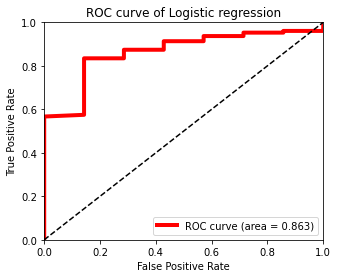

In [131]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC를 계산합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve 그래프를 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

### [분류 모델 계산]
**클래스 불균형 문제 해결하기**

In [132]:
# y가 0과 1을 각각 얼마나 가지고 있는지 출력해 보자
df['y'].value_counts()

1    412
0     33
Name: y, dtype: int64

**오류 참고 주소: https://stackoverflow.com/questions/39175963/sampling-n-2000-from-a-dask-dataframe-of-len-18000-generates-error-cannot-take?rq=1**

In [134]:
# 1:1 비율로 랜덤 샘플링을 수행합니다.
positive_random_idx = df[df['y']==1].sample(50, random_state=30, replace=True).index.tolist()
negative_random_idx = df[df['y']==0].sample(50, random_state=30, replace=True).index.tolist()

In [136]:
# 랜덤 데이터로 데이터셋을 나눕니다.
random_idx = positive_random_idx + negative_random_idx
sample_X = X[random_idx, :]
y = df['y'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(sample_X, y, test_size=0.30)
print(x_train.shape)
print(x_test.shape)

(70, 2254)
(30, 2254)


**Logistic Regression 재학습**

In [137]:
# 로지스틱 회귀모델을 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 로지스틱 회귀모델의 성능을 평가합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.80
Precision : 0.700
Recall : 1.000
F1 : 0.824


In [138]:
# Confusion Matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[10  6]
 [ 0 14]]


AUC : 0.862


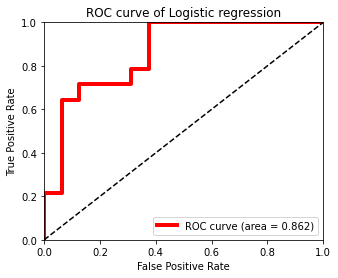

In [139]:
# AUC를 계산합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve 그래프를 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

## <step4. 활용> : 중요 키워드 분석
### [회귀 모델의피처 영향력 추출]

<BarContainer object of 2254 artists>

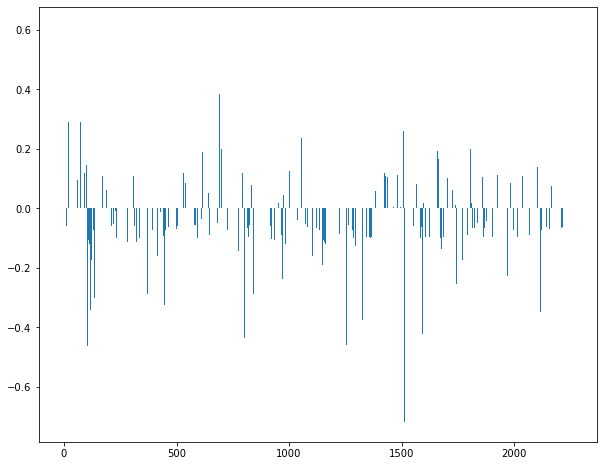

In [141]:
# 학습한 회귀 모델의계수를 출력합니다. 
plt.rcParams['figure.figsize'] = [10,8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [143]:
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

[(0.6107329741789647, 706), (0.5465660347748098, 1456), (0.5314283602352956, 647), (0.38690738793749463, 1891), (0.3855201985077174, 691)]
[(-0.43745034627501783, 802), (-0.45730995709497685, 2115), (-0.458640890471782, 1255), (-0.46450163266861955, 104), (-0.7188163779642064, 1513)]


### [중요 피처의 형태소 ]

In [147]:
# 회귀 모델의 계수를 높은 순으로 정렬합니다. 
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)

In [148]:
# 회귀 모델의 계수를 index_vectorizer에 맵핑하여, 어떤 형태소인지 출력할 수 있게 합니다.
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}

# 계수가 높은 순으로, 피처에 형태소를 맵핑한 결과를 출력합니다. 계수가 높은 피처는 리뷰에 긍정적인 영향을 주는 형태소라고 할 수 있습니다.
print(str(invert_index_vectorizer)[:100]+'..')

{796: '모/Noun', 555: '둠이랑/Verb', 604: '라면/Noun', 429: '다/Adverb', 376: '너무/Adverb', 722: '맜/Noun', 1..


In [149]:
# 상위 20개의 긍정 형태소를 출력합니다. 

for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

맛있어요/Adjective 0.6107329741789647
완전/Noun 0.5465660347748098
만족/Noun 0.5314283602352956
집/Noun 0.38690738793749463
맛있게/Adjective 0.3855201985077174
nan/Alpha 0.35385647474587484
갑니다/Verb 0.32770186373904636
먹었습니다/Verb 0.29291444577283676
감사합니다/Verb 0.29069341579856284
가도/Noun 0.2898684552545704
방문/Noun 0.2838251556878998
언/Modifier 0.27152470722670113
기분/Noun 0.2629471289871426
먹고/Verb 0.26259184829108256
육회/Noun 0.26018203834121467
좋고/Adjective 0.24865799984376014
춥긴/Verb 0.24558927576847076
먹었/Verb 0.24558927576847076
니데/Noun 0.24558927576847076
미테/Adjective 0.24302303578201806


In [150]:
# 상위 20개 부정 형태소를 출력합니다. 
for coef in coef_pos_index[-20:]:
    print(invert_index_vectorizer[coef[1]], coef[0])

다양한/Adjective -0.32385164226270907
손님/Noun -0.3346141683287514
이/Josa -0.334995488506578
가/Josa -0.33743687681172346
거/Noun -0.3424368104188204
하나/Noun -0.35002354937771274
을/Josa -0.36445819899158
어디가/Noun -0.3746185963984089
메뉴/Noun -0.3764696198326689
친절하셨어요/Adjective -0.3901256474888636
크게/Noun -0.39347939275593613
맛/Noun -0.40580407042813377
모르겠음/Verb -0.4200621921946905
매력/Noun -0.4200621921946905
인지/Josa -0.42356673403937495
모르겠지만/Verb -0.43745034627501783
하기엔/Verb -0.45730995709497685
안/VerbPrefix -0.458640890471782
같아요/Adjective -0.46450163266861955
은/Josa -0.7188163779642064


### `[미니 퀴즈 - 4.3]`
- `피처 영향력에 따라 정렬된 형태소에서, 품사별 긍정 형태소 10개와 부정 형태소 10개를 탐색해 보세요.` 
    - “/”로 구분되어있는 정보를 활용하여 품사별 형태소를 추출할 수 있습니다.

In [152]:
noun_list = []
adjective_list = []

# 명사, 형용사별로 계수가 높은 상위 10개의 형태소를 추출합니다. 이는 리뷰에 긍정적인 영향을 주는 명사와 형용사를 순위별로 살펴보는 것이 됩니다.
for coef in coef_pos_index[:100]:
    pos_category = invert_index_vectorizer[coef[1]].split("/")[1]
    if pos_category == "Noun":
        noun_list.append((invert_index_vectorizer[coef[1]], coef[0]))
    elif pos_category == "Adjective":
        adjective_list.append((invert_index_vectorizer[coef[1]], coef[0]))

In [153]:
# 상위 10개의 명사를 출력합니다. 
noun_list[:10]

[('완전/Noun', 0.5465660347748098),
 ('만족/Noun', 0.5314283602352956),
 ('집/Noun', 0.38690738793749463),
 ('가도/Noun', 0.2898684552545704),
 ('방문/Noun', 0.2838251556878998),
 ('기분/Noun', 0.2629471289871426),
 ('육회/Noun', 0.26018203834121467),
 ('니데/Noun', 0.24558927576847076),
 ('리언/Noun', 0.24302303578201806),
 ('삼겹살/Noun', 0.2371205889847166)]

In [154]:
# 상위 10개의 형용사를 출력합니다. 
adjective_list[:10]

[('맛있어요/Adjective', 0.6107329741789647),
 ('맛있게/Adjective', 0.3855201985077174),
 ('좋고/Adjective', 0.24865799984376014),
 ('미테/Adjective', 0.24302303578201806),
 ('쎈/Adjective', 0.22216662992137823),
 ('좋았어요/Adjective', 0.19931245448660287),
 ('맛있는데/Adjective', 0.19813197334631116),
 ('친절하시고/Adjective', 0.1793736242135859),
 ('좋습니다/Adjective', 0.1754644897331162),
 ('친절하고/Adjective', 0.14916303009051413)]